In [ ]:
#!pip install seaborn==0.11.2 tqdm matplotlib==3.7.0 statannot

In [ ]:
# run this script undere domino standard > 5.7 
!pip install statannot openpyxl nibabel seaborn boto3==1.35.20 fsspec s3fs==2024.9.0
!{'sudo apt-get install -y sshpass awscli'}

In [6]:
import numpy as np
import pandas as pd
import shutil, itertools , glob , os ,csv, re, itertools
from scipy.stats import pearsonr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns # --> Restart Kernel
import nibabel as nb
from statannot import add_stat_annotation

### Data Path

In [7]:
path_data = '/domino/edv/nfs-pvc/taupet/'
study_name = 'ADNIpet'
output_proc = 'Proc.domino.v1'
file_to_read = '/best/1Dstats/aparc.a2009s+aseg_rank.al.mid.PET.SUV.T807.BL.al.mid.Cerebellum.cortex.suvr.avg.stats.1D'

In [8]:
os.chdir('/domino/edv/nfs-pvc/taupet/ADNIpet')
print (os.listdir('.'))

['VROI.log', 'adni_tau.05022025.cmp_NScerebellar_gray.Xc0.10sub.1atl.690883c573cbc6de2d455f09ecc71385.rres-01.rds', 'Proc.test', '.Rhistory', 'Proc.p', 'ADNIpet_local_abalysis_SUVRs.csv', 'NIFTI', '.ipynb_checkpoints', 'adni_tau.05022025.cmp_NScerebellar_gray.Xc0.10sub.1atl.690883c573cbc6de2d455f09ecc71385.rres.rds', 'README', 'adni_tau.05022025.cmp_NScerebellar_gray.Xc0aa396d675474673c6f41fe4c7934f153.rres-01.rds', 'tmp', 'ADNI.normative.subjectIDs.07122022.csv', 'normative_subjects.txt', 'synthseg_QC.xlsx', 'Proc.domino.v1', 'adni_tau.05022025.cmp_NScerebellar_gray.Xc0aa396d675474673c6f41fe4c7934f153.rres.rds', 'ADNI-Diag.xlsx', 'subject_list', 'report_adni_aws.csv']


### Reading the Diagnosis and SUVR values

In [9]:
os.chdir(os.path.join(path_data, study_name))

#reading the diagnosis file
diag_file_tmp = pd.read_excel('/mnt/early_scripts/ADNI-Diag_TW.xlsx')
diag_file_tmp = diag_file_tmp.loc[diag_file_tmp['TAUPET_avisit']=='BL',:]
diag_file = diag_file_tmp.rename(columns={'sub':'sid','BL.nsb.diag':'diag'})\
                [['sid','diag', 'TAUPET_avisit' , 'BL.AmyloidStatus','BL.nsb.age']]\
                .drop_duplicates('sid')\
                .reset_index(drop=True)

# filter subjects with amyloid positive or negative
diag_file = diag_file[diag_file['BL.AmyloidStatus'].isin(['pos','neg'])]
# change the dignosis 
dict_pos_neg={'pos':'+', 'neg':'-'}
diag_file['BL.AmyloidStatus_new']=diag_file['BL.AmyloidStatus'].map(dict_pos_neg)
diag_file['diag_status'] = diag_file['diag'] + diag_file['BL.AmyloidStatus_new']

# drop AD negative because of statistical power
diag_file_noADneg = diag_file[~(diag_file['diag_status']=='AD-')]

#diag_file = diag_file.drop(columns=['diag', 'TAUPET_avisit','BL.AmyloidStatus','BL.AmyloidStatus_new'])
#diag_file.rename(columns={'diag_status':'diag'}, inplace=True)

# find all subject ids
subjects_list = diag_file_noADneg['sid'].tolist()
# number of avialble subjects
len(subjects_list)

753

### Demographic of Subjects

In [10]:
diag_file.groupby('diag').count()

,sid,TAUPET_avisit,BL.AmyloidStatus,BL.nsb.age,BL.AmyloidStatus_new,diag_status
diag,,,,,,
AD,82,82,82,82,82,82
CN,427,427,427,427,427,427
MCI,256,256,256,256,256,256


In [11]:
diag_file[['sid','diag','BL.AmyloidStatus']].groupby(['diag','BL.AmyloidStatus']).count()

sid
diag BL.AmyloidStatus     
AD   neg                12
     pos                70
CN   neg               301
     pos               126
MCI  neg               137
     pos               119

In [12]:
diag_file[['diag','BL.nsb.age']].groupby('diag').mean().round()

,BL.nsb.age
diag,
AD,76.0
CN,72.0
MCI,74.0


In [13]:
diag_file[['diag','BL.nsb.age']].groupby('diag').std().round()

,BL.nsb.age
diag,
AD,8.0
CN,7.0
MCI,8.0


### Braak Areas

In [14]:
Braak_areas = {
    'Braak_1':['ctx-lh-entorhinal',
               'ctx-rh-entorhinal'],
    
    'Braak_2':['Right-Hippocampus',
               'Left-Hippocampus'],
    
    'Braak_3':[ 'ctx-lh-parahippocampal',
                'ctx-rh-parahippocampal',
                'ctx-lh-fusiform',
                'ctx-rh-fusiform',
                'ctx-lh-lingual',
                'ctx-rh-lingual',
                'Left-Amygdala',
                'Right-Amygdala'],
    
    'Braak_4':[ 'ctx-lh-middletemporal',
                'ctx-rh-middletemporal',          
                'Left-Thalamus',  #'Left-Thalamus-Proper' does not exit
                'Right-Thalamus', #'Right-Thalamus-Proper' does not exit
                'ctx-lh-caudalanteriorcingulate',
                'ctx-rh-caudalanteriorcingulate',
                'ctx-lh-rostralanteriorcingulate',
                'ctx-rh-rostralanteriorcingulate',
                'ctx-lh-posteriorcingulate',
                'ctx-rh-posteriorcingulate',   
                'ctx-lh-isthmuscingulate',
                'ctx-rh-isthmuscingulate',    
                'ctx-lh-insula',
                'ctx-rh-insula',                
                'ctx-lh-inferiortemporal',
                'ctx-rh-inferiortemporal',      
                'ctx-lh-temporalpole',
                'ctx-rh-temporalpole'],
    
    'Braak_5':['ctx-lh-superiorfrontal',
                'ctx-rh-superiorfrontal',
                'ctx-lh-lateralorbitofrontal',
                'ctx-rh-lateralorbitofrontal',
                'ctx-lh-medialorbitofrontal',
                'ctx-rh-medialorbitofrontal',
                'ctx-lh-frontalpole',
                'ctx-rh-frontalpole',         
                'ctx-lh-caudalmiddlefrontal',
                'ctx-rh-caudalmiddlefrontal',
                'ctx-lh-rostralmiddlefrontal',
                'ctx-rh-rostralmiddlefrontal',
                'ctx-lh-parsopercularis',
                'ctx-rh-parsopercularis',     
                'ctx-lh-parsorbitalis',
                'ctx-rh-parsorbitalis',       
                'ctx-lh-parstriangularis',
                'ctx-rh-parstriangularis',
                'Left-Caudate',
                'Right-Caudate',              
                'Left-Putamen',
                'Right-Putamen',              
                'ctx-lh-lateraloccipital',
                'ctx-rh-lateraloccipital',    
                'ctx-lh-supramarginal',
                'ctx-rh-supramarginal',    
                'ctx-lh-inferiorparietal',
                'ctx-rh-inferiorparietal',    
                'ctx-lh-superiortemporal',
                'ctx-rh-superiortemporal',
                'Left-Pallidum',
                'Right-Pallidum',             
                'ctx-lh-superiorparietal',
                'ctx-rh-superiorparietal',    
                'ctx-lh-precuneus',
                'ctx-rh-precuneus',           
                'ctx-lh-bankssts',
                'ctx-rh-bankssts',            
                'Left-Accumbens-area',
                'Right-Accumbens-area',       
                'ctx-lh-transversetemporal',
                'ctx-rh-transversetemporal'],
    
    'Braak_6':['ctx-lh-pericalcarine',
                'ctx-rh-pericalcarine',
                'ctx-lh-postcentral',
                'ctx-rh-postcentral',
                'ctx-lh-cuneus',
                'ctx-rh-cuneus',      
                'ctx-lh-precentral',
                'ctx-rh-precentral',
                'ctx-lh-paracentral',  
                'ctx-rh-paracentral']}


Braak_areas_list = list(itertools.chain.from_iterable(list(Braak_areas.values())))

### Convert SUVR_1D file to Braak

In [15]:
 def suvr_1d_to_braak(proc_path, sid, file_to_read):

    # proc_path = '/domino/datasets/local/Tau_PET_spread_endpoint/ADNIpet.Proc.domino.v1/'
    # file_to_read = '/best/1Dstats/aparc+aseg_rank.al.mid.PET.SUV.T807.BL.al.mid.Cerebellum.cortex.suvr.avg.stats.1D'
    # sid = '002_S_0413'
    
    # creating the proc path
    suvr_1d_file = proc_path + '/' + sid + '/' + file_to_read

    braak_areas_suvr={'sid': sid}
    if os.path.exists(suvr_1d_file):
        suvr_data = pd.read_csv(suvr_1d_file, delimiter='\t')

        # selecting the mean value for each regions    
        suvr_data_nzmean = suvr_data[suvr_data.columns[suvr_data.columns.str.contains('NZMean')]]
        suvr_data_nzcount = suvr_data[suvr_data.columns[suvr_data.columns.str.contains('NZcount')]]

        # remove NZmean from column name
        suvr_data_nzmean.columns = suvr_data_nzmean.columns.str[7:]
        suvr_data_nzcount.columns = suvr_data_nzcount.columns.str[8:]

        # check all braak reagions exist in the suvr file
        if sum(suvr_data_nzmean.columns.isin(Braak_areas_list))==len(Braak_areas_list):

            # calculating the braak avearge from aseg-aparc regions weighted mean by using voxel counts
            for n in np.arange(1,7):
                
                # calculating total voxels
                total_voxels = suvr_data_nzcount[Braak_areas['Braak_' + str(n)]].sum(axis=1).values[0]

                # merging voxel count and suvr values
                area_suvr_voxel_count = pd.concat([suvr_data_nzmean[Braak_areas['Braak_' + str(n)]] ,
                                                   suvr_data_nzcount[Braak_areas['Braak_' + str(n)]]]).reset_index(drop=True)

                # calcualting weighted mean
                weighted_mean = (area_suvr_voxel_count.loc[0,:] * area_suvr_voxel_count.loc[1,:]).sum()/total_voxels
                braak_areas_suvr['Braak_' + str(n) + '_wmean'] = weighted_mean
        else:
            print('the braak regions are not complete')
    #creating dataframe
    braak_areas_suvr = pd.DataFrame(pd.Series(braak_areas_suvr)).T
        
    return braak_areas_suvr

### Data from Domino Analysis

In [16]:
tmp =[]
proc_path = path_data + study_name + '/' + output_proc + '/'
suvr_1d = '/best/1Dstats/aparc+aseg_rank.al.mid.PET.SUV.T807.BL.al.mid.Cerebellum.cortex.suvr.avg.stats.1D'
for sid in tqdm(subjects_list):
    # reading individual braak data
    subj_data= suvr_1d_to_braak(proc_path = proc_path,
                                sid = sid ,
                                file_to_read = suvr_1d)
    # add to temporal list
    tmp.append(subj_data)

# merge all data
roi_suvr_domino = pd.concat(tmp).reset_index(drop=True).dropna()

100%|██████████| 753/753 [00:25<00:00, 29.74it/s]


In [17]:
roi_suvr_domino

,sid,Braak_1_wmean,Braak_2_wmean,Braak_3_wmean,Braak_4_wmean,Braak_5_wmean,Braak_6_wmean
0,002_S_4213,0.994925,0.955459,0.99844,0.994751,0.987095,0.908219
1,002_S_4229,1.071647,1.018751,1.052275,1.07512,1.097696,1.063166
2,002_S_4262,1.883834,1.535428,1.735146,1.796119,1.702785,1.319834
3,002_S_4521,2.001569,1.580687,1.787095,2.086781,1.964152,1.274737
4,002_S_4654,1.430322,1.609915,1.303099,1.301516,1.248476,1.120163
...,...,...,...,...,...,...,...
748,941_S_6580,1.257047,1.236285,1.129778,1.158714,1.129613,1.074882
749,941_S_6581,1.171415,1.281521,1.068997,1.122285,1.079641,0.952314
750,941_S_6803,2.005544,1.34211,2.231702,1.933733,1.697789,1.389159
751,941_S_6854,1.780874,1.70753,1.536376,1.503655,1.306386,1.111459


In [18]:
group_roi_suvr = roi_suvr_domino

### Plotting

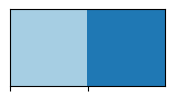

In [19]:
custom_palette1 = sns.color_palette('Paired',8)[0:2][:]
sns.palplot(custom_palette1)

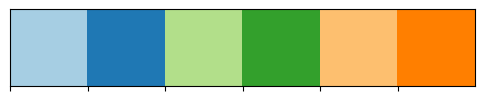

In [20]:
custom_palette2 = sns.color_palette('Paired',8)[0:4][:] + sns.color_palette('Paired',8)[6:8][:]
sns.palplot(custom_palette2)

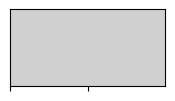

In [21]:
custom_palette3 = sns.color_palette(palette='Greys')[1], sns.color_palette(palette='Greys')[1]
sns.palplot(custom_palette3)

### Ploting

/home/ubuntu/.local/lib/python3.10/site-packages/statannot/statannot.py:555: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'star':
/home/ubuntu/.local/lib/python3.10/site-packages/statannot/statannot.py:557: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'simple':
/home/ubuntu/.local/lib/python3.10/site-packages/statannot/statannot.py:555: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'star':
/home/ubuntu/.local/lib/python3.10/site-packages/statannot/statannot.py:557: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'simple':


AttributeError: module 'seaborn.categorical' has no attribute '_BoxPlotter'

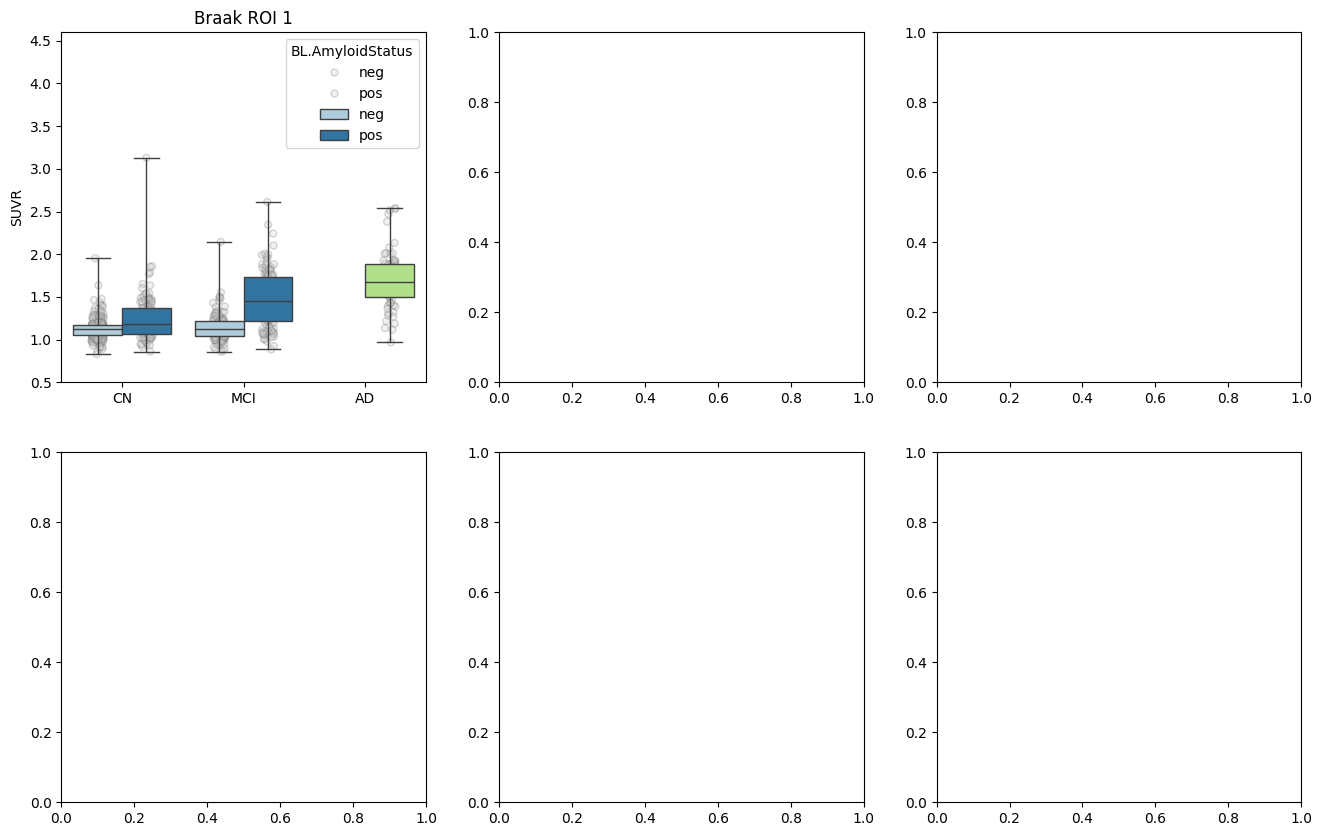

In [24]:
Braak_regions = roi_suvr_domino.columns[roi_suvr_domino.columns.str.contains('Braak')]

# generating pairwise for t-test
pairwiseMatrix = [(("CN", "pos"), ("CN", "neg")), 
                  (("MCI", "pos"), ("MCI", "neg")),
                  (("MCI", "pos"), ("CN", "pos")),
                  (("AD", "pos"), ("CN", "pos")),
                  (("AD", "pos"), ("MCI", "pos"))] #list(itertools.combinations(diag_file['diag'].unique().tolist(), 2))

fig, axs = plt.subplots(figsize=(16, 10), nrows=2, ncols=3)
n1axs = 0
n2axs = 0
# Plot region plots for each region containing the specified substrings
for roi_name in Braak_regions:

        # Remove 'NZ_Mean_' from region_column
        plot_title = str(roi_name).replace('wmean', '').replace('_', ' ROI ', 1).replace('_', '',1)
        
        # extract the SUVR
        roi_suvr = group_roi_suvr[['sid',roi_name]]
        
        # adding the best cost and diagnosis
        roi_suvr = pd.merge(roi_suvr,diag_file, on='sid')
        
        # Cohorts SUVR
        renamed_roi_suvr = roi_suvr[[roi_name,'diag','BL.AmyloidStatus']]\
                                    .set_index('diag')\
                                    .reset_index()\
                                    .rename(columns={roi_name:'SUVR'})
        # change SUVR to float
        renamed_roi_suvr['SUVR'] = renamed_roi_suvr['SUVR'].astype(float)
        
        # Add in points to show each observation
        sns.stripplot(data= renamed_roi_suvr, 
                      x='diag',
                      y='SUVR', 
                      dodge=True,
                      zorder=0,
                      hue='BL.AmyloidStatus',
                      palette=custom_palette3,
                      marker="o", linewidth=1, alpha=.3,
                      ax=axs[n1axs,n2axs])
        
        # Plot the orbital period with horizontal boxes
        sns.boxplot(
            data= renamed_roi_suvr, 
            x='diag', 
            y='SUVR', 
            hue='BL.AmyloidStatus',
            whis=[0, 100],
            width=.8,
            palette= custom_palette1,
            ax=axs[n1axs,n2axs])
        
        # Select which box you want to change, change the appearance of that box
        mybox = axs[n1axs,n2axs].patches[4]
        mybox.set_facecolor(custom_palette2[2])
        mybox = axs[n1axs,n2axs].patches[5]
        mybox.set_facecolor(custom_palette2[3])
        mybox = axs[n1axs,n2axs].patches[6]
        mybox.set_facecolor(custom_palette2[5])
        
        # Tweak the visual presentation
        axs[n1axs,n2axs].set(ylabel="SUVR")
        axs[n1axs,n2axs].set(xlabel="")
        axs[n1axs,n2axs].set(title=plot_title)
        axs[n1axs,n2axs].set_ylim([0.5,4.6])
        
        # ------------------------------- Star Threshold  -------------------------------             
        ## ns: 5.00e-02 < p <= 1.00e+00
        ## *: 1.00e-02 < p <= 5.00e-02
        ## **: 1.00e-03 < p <= 1.00e-02
        ## ***: 1.00e-04 < p <= 1.00e-03
        ## ****: p <= 1.00e-04   
        # ------------------------------- Star Threshold  -------------------------------   
#         ThresholdStar = [[1e-6, "****"],
#                          [1e-5, "***"],
#                          [1e-4, "**"],
#                          [0.003, "*"], 
#                          [1, "ns"]]
        
        """
        # plotting the t-test comparison pairwise
        add_stat_annotation(axs[n1axs,n2axs],
                data=renamed_roi_suvr,
                x='diag',
                y='SUVR',  
                hue='BL.AmyloidStatus',          
                box_pairs=pairwiseMatrix,
                test='t-test_ind',
                line_offset_to_box=0.03,
                line_offset=0.01, 
                comparisons_correction='bonferroni',
#                 pvalue_thresholds= ThresholdStar, # star difiniation
                text_format='star',
                verbose=0)
        """
        
        axs[n1axs,n2axs].set(ylabel='standardized uptake value ratio')
        axs[n1axs,n2axs].get_legend().set_visible(False)
        axs[n1axs,n2axs].set_xticks(np.arange(3), ['  CN-    CN+', '  MCI-   MCI+', '       AD+']) 
        
        if n2axs==2:
            n1axs +=1
            n2axs = 0
        else:    
            n2axs +=1

fig.suptitle('Comparison of the standard uptake value ratio (SUVR)' + \
             ' in different cohorts:\n generated by TauQuant pipeline ' +\
             'from Tau-PET images',y=0.96, fontsize=16, ha='center')        
#fig.supxlabel('Cohort comparision using TauQuant pipeline',y=0.03, fontsize=15)
plt.savefig('/mnt/results/SUVR_tauquant.pdf', dpi=1200)
plt.show()
#plt.close()
print(renamed_roi_suvr.groupby('diag').count().rename(columns={'SUVR':'#N'}))